In [ ]:
import os
import sys
import time
import csv
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models  
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import ImageDraw 
from tqdm import tqdm
import torch.optim as optim  
import torch.nn.functional as F
import json
import pandas as pd
from datetime import datetime
import pdb 
from google.colab import drive
from psutil import virtual_memory
from zipfile import ZipFile
from sklearn.cluster import KMeans
import xml.etree.ElementTree as ET
import torchvision.transforms as transforms
from sklearn.preprocessing import normalize

#Make sure to mount drive and that you have access to IDL_group_project. All paths are from the shared folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://github.com/csgwon/pytorch-deconvnet/blob/dfb8cd6e1ab0ecf3da0fd63476e8b269744fadba/models/vgg16_deconv.py#L92

In [ ]:
#This function will return both the path and the file names of all files in a directory
def path_file_list_creator(path, both_path_file = False):
  path_file_list = []
  for myfile in os.listdir(path):
    full_path = os.path.join(path,myfile)
    if both_path_file == True:
      path_file_list.append((full_path, myfile))
    else:
      path_file_list.append(full_path)

  return(path_file_list,len(path_file_list))

#Concate all different classes semantic information together from seperate directories
def concate_directories(paths):
  semantic_bundles_paths_extended = []
  total_files = 0 

  for path in paths:
    class_bundle_paths , num_files = path_file_list_creator(path)
    semantic_bundles_paths_extended.extend(class_bundle_paths)
    total_files += num_files
  print("Total Files grabbed ", total_files)
  return(semantic_bundles_paths_extended)

In [ ]:
#This displays and masks an image. Can be used to verify correct semantic objects are extracted
def display_mask_image(binary_mask, image_path, label, semantic_type):
  binary_mask = np.stack([binary_mask, binary_mask, binary_mask], axis=2)
  image = Image.open(image_path)
  image = np.asarray(image)
  masked_image = binary_mask * image
  masked_image = Image.fromarray(masked_image)
  
  #Annotations
  print("Image File: ", image_path)
  print("Class: ", label)
  print("Semantic_type: ", semantic_type)
  display(masked_image)

#This masks a image and converts the image into a pytorch tensor
def convert_mask_image(binary_mask, image_path):
  binary_mask = np.stack([binary_mask, binary_mask, binary_mask], axis=2)
  image = Image.open(image_path)
  image = np.asarray(image)

  masked_image = binary_mask * image
  transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  #masked_image = torchvision.transforms.functional.to_tensor(masked_image)
  masked_image = transforms(masked_image)
  masked_image = torch.unsqueeze(masked_image, dim = 0)

  return(masked_image)

In [ ]:
class SemanticObjectsLoader(DataLoader):
  def __init__(self, paths, image_folder_path, target_lables):
    self.paths = concate_directories(paths)
    self.image_folder_dir = image_folder_path
    self.target_labels = target_labels
  def __iter__(self):

    for i, path in enumerate(self.paths):
      with open(path, 'rb') as f:
        data = pickle.load(f)
      image_name = data['image_name']
      #We must append the full path name to image_name
      image_name = self.image_folder_dir + image_name + '.jpg'
      num_objects = data["num_objects"]
      #we must iterate through every different object (for example there could be two airplanes in one photo)
      for object_index in range(num_objects):
        #Crawling through each object index
        label = data['objects_list'][object_index]['obj_class']
        if label in self.target_labels:
         
          #We must iterate through every semantic item now
          for semantic_index in range(len(data['objects_list'][object_index]['parts_list'])):
            semantic_mask = data['objects_list'][object_index]['parts_list'][semantic_index]['part_mask']
            semantic_type = data['objects_list'][object_index]['parts_list'][semantic_index]['part_name']
            #Fill in a new entry into the dictionary
            meta_dict = {"image_name": image_name, "label" : label, "semantic_mask" : semantic_mask, "semantic_type" :semantic_type}
            yield meta_dict

    yield full_semantic_list_getter(self.paths)

In [ ]:
def get_nonzero_feature_vectors(max_pool_layer_4_representation):
  max_pool_layer_4_representation = max_pool_layer_4_representation.detach().cpu()
  batch_indices, channel_indices, width_idices, height_indices = torch.nonzero(max_pool_layer_4_representation, as_tuple=True)
  feature_vector_list = []
  for non_zero_index in range(len(batch_indices)):
    feature_vector = max_pool_layer_4_representation[0, : ,width_idices[non_zero_index], height_indices[non_zero_index]].numpy()
    feature_vector_list.append(feature_vector)
  return(feature_vector_list)


In [ ]:
aeroplane_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/aeroplane'
bicycle_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bicycle'
bus_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bus'
car_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/car'
motorbike_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/motorbike'
train_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/train'
image_folder_dir = '/content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/'
target_labels = ['aeroplane', 'bicycle', 'bus', 'car', 'motorbike', 'train']

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = models.vgg16(pretrained=True).features[:24].to(device)

all_classes_semantic_paths = [aeroplane_annotations_path,bicycle_annotations_path,bus_annotations_path,car_annotations_path,motorbike_annotations_path,train_annotations_path]
semantic_dataloader = SemanticObjectsLoader(all_classes_semantic_paths, image_folder_dir, all_classes_semantic_paths)

cpu


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Total Files grabbed  3351


Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000021.jpg
Class:  aeroplane
Semantic_type:  body


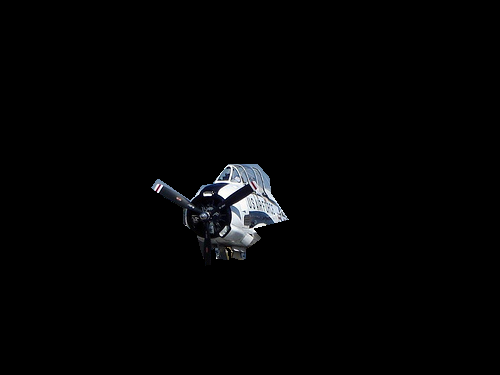

In [ ]:
for i, x in enumerate(semantic_dataloader):
  image = display_mask_image(x['semantic_mask'],x['image_name'], x['label'],x['semantic_type'])
  break

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000021.jpg
Class:  aeroplane
Semantic_type:  body


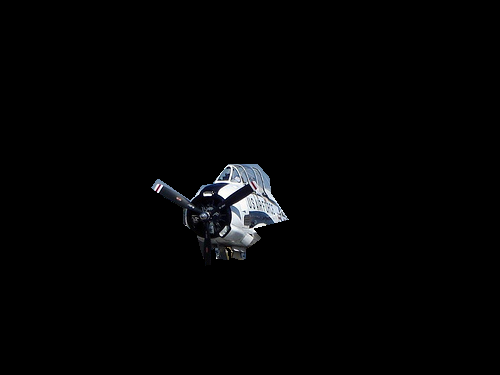

In [ ]:
from numpy import linalg as LA
for meta_dict in semantic_dataloader:
  label, semantic_type = meta_dict['label'], meta_dict['semantic_type']
  image = convert_mask_image(meta_dict['semantic_mask'],meta_dict['image_name']).to(device)
  max_pool4_output = model(image)
  non_zero_feature_vectors = np.array(get_nonzero_feature_vectors(max_pool4_output))
  display_mask_image(meta_dict['semantic_mask'],meta_dict['image_name'], meta_dict['label'],meta_dict['semantic_type'])
  break

In [ ]:
import torch
import torchvision.models as models

import numpy as np

vgg16_pretrained = models.vgg16(pretrained=True).features[:24].to(device)
class VGG16_conv(torch.nn.Module):
    def __init__(self):
        super(VGG16_conv, self).__init__()
        # VGG16 (using return_indices=True on the MaxPool2d layers)
        self.features = torch.nn.Sequential(
            # conv1
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv2
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv3
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv4
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),)
        self.feature_outputs = [0]*len(self.features)
        self.pool_indices = dict()
        self._initialize_weights()


    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained):
            if isinstance(layer, torch.nn.Conv2d):
                self.features[i].weight.data = layer.weight.data
                self.features[i].bias.data = layer.bias.data

    def get_conv_layer_indices(self):
        return [0, 2, 5, 7, 10, 12, 14, 17, 19, 21]

    def forward_features(self, x):
        output = x
        for i, layer in enumerate(self.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
                self.feature_outputs[i] = output
                self.pool_indices[i] = indices
            else:
                output = layer(output)
                self.feature_outputs[i] = output
        return output

    def forward(self, x):
        output = self.forward_features(x)
        return output

class VGG16_deconv(torch.nn.Module):
    def __init__(self):
        super(VGG16_deconv, self).__init__()
        self.conv2DeconvIdx = {0:13, 2:12, 5:10, 7:9, 10:7, 12:6, 14:5, 17:3, 19:2, 21:1}
        self.conv2DeconvBiasIdx = {0:12, 2:10, 5:9, 7:7, 10:6, 12:5, 14:3, 17:2, 19:1, 21:0}
        self.unpool2PoolIdx = {11:4, 8:9, 4:16, 0:23}
        
        self.deconv_features = torch.nn.Sequential(
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 256, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(128, 128, 3, padding=1),
            torch.nn.ConvTranspose2d(128, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.ConvTranspose2d(64, 3, 3, padding=1))

        # not the most elegant, given that I don't need the MaxUnpools here
        self.deconv_first_layers = torch.nn.ModuleList([
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 3, 3, padding=1) ])

        self._initialize_weights()

    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained):
            if isinstance(layer, torch.nn.Conv2d):
                self.deconv_features[self.conv2DeconvIdx[i]].weight.data = layer.weight.data
                biasIdx = self.conv2DeconvBiasIdx[i]
                if biasIdx > 0:
                    self.deconv_features[biasIdx].bias.data = layer.bias.data
                

    def forward(self, x, layer_number, map_number, pool_indices):
        start_idx = self.conv2DeconvIdx[layer_number]
        if not isinstance(self.deconv_first_layers[start_idx], torch.nn.ConvTranspose2d):
            raise ValueError('Layer '+str(layer_number)+' is not of type Conv2d')
        # set weight and bias
        self.deconv_first_layers[start_idx].weight.data = self.deconv_features[start_idx].weight[map_number].data[None, :, :, :]
        self.deconv_first_layers[start_idx].bias.data = self.deconv_features[start_idx].bias.data        
        # first layer will be single channeled, since we're picking a particular filter
        output = self.deconv_first_layers[start_idx](x)

        # transpose conv through the rest of the network
        for i in range(start_idx+1, len(self.deconv_features)):
            if isinstance(self.deconv_features[i], torch.nn.MaxUnpool2d):
                output = self.deconv_features[i](output, pool_indices[self.unpool2PoolIdx[i]])
            else:
                output = self.deconv_features[i](output)
        return output

In [ ]:
conv_out = vgg16_c()
vgg16_d = VGG16_deconv()

In [ ]:
visual_concepts = np.load('/content/drive/MyDrive/IDL_group_project/visual_concepts_positive.npy')
final_indicies = [6, 17, 43, 47, 52, 56, 63, 75, 78, 82, 89, 91, 96, 104, 107, 111, 122, 140, 150, 164, 172, 187, 194]
visual_concepts = visual_concepts[final_indicies]

NameError: ignored